In [1]:
%pylab inline
import json
import math
import string
import numpy as np
import pandas as pd
import scipy.stats as stats
from suffix_tree import SuffixTree
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

Populating the interactive namespace from numpy and matplotlib


In [5]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

In [49]:
def cluster_data():

    data = [
        
        ['employed', 'housewife', 'retired', 'student', 'unemployed'],
        ('cluster id: 38', [
            [0.46, 0.34, 0.14, 0.03, 0.03, ],]),
        ('cluster id: 0', [
            [0.61, 0.21, 0.08, 0.06, 0.04, ],]),
        ('cluster id: 1', [
            [0.51, 0.30, 0.11, 0.05, 0.03, ],]),
        ('cluster id: 29', [
            [0.55, 0.26, 0.10, 0.06, 0.04,],]),
        ('cluster id: 40', [
            [0.70, 0.14, 0.04, 0.09, 0.04, ],]),
        ('cluster id: 24', [
            [0.50, 0.31, 0.11, 0.05, 0.04, ],])
    ]
    return data

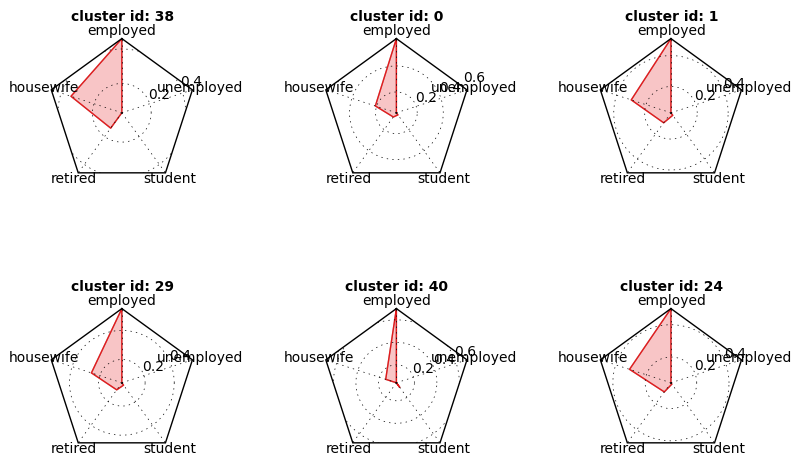

In [58]:
N = 5
theta = radar_factory(N, frame='polygon')

data = cluster_data()
spoke_labels = data.pop(0)

fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=3,
                         subplot_kw=dict(projection='radar'))

fig.subplots_adjust(wspace=0.85, hspace=-0.4, top=0.85, bottom=0.05)
#fig.tight_layout()

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axes.flatten(), data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d in case_data:
        ax.plot(theta, d, color='#e41a1c')
        ax.fill(theta, d, facecolor='#e41a1c', alpha=0.25)
    ax.set_varlabels(spoke_labels)


plt.show()

In [ ]:
['employed', 'housewife', 'retired', 'student', 'unemployed'],
        ('cluster id: 38', [
            [0.46, 0.34, 0.14, 0.03, 0.03, ],]),
        ('cluster id: 0', [
            [0.61, 0.21, 0.08, 0.06, 0.04, ],]),
        ('cluster id: 1', [
            [0.51, 0.30, 0.11, 0.05, 0.03, ],]),
        ('cluster id: 29', [
            [0.55, 0.26, 0.10, 0.06, 0.04,],]),
        ('cluster id: 40', [
            [0.70, 0.14, 0.04, 0.09, 0.04, ],]),
        ('cluster id: 24', [
            [0.50, 0.31, 0.11, 0.05, 0.04, ],])

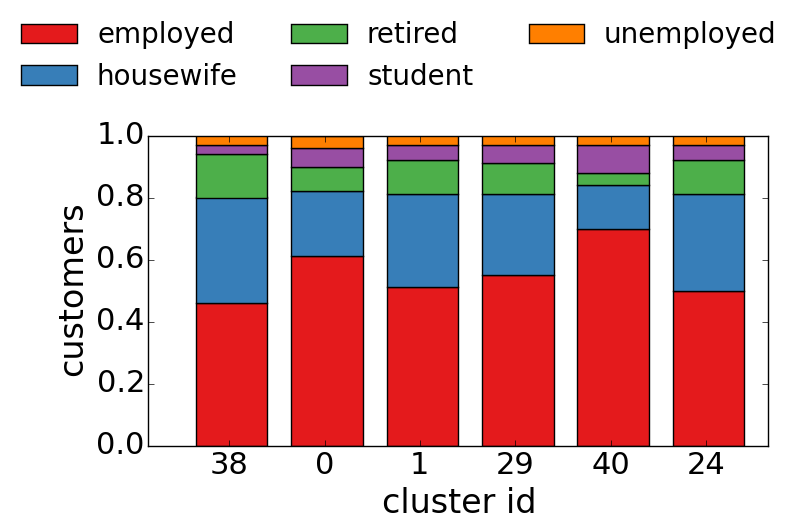

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))

N = 6

ind = np.arange(N)    # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

cluster38 = np.asarray([0.46, 0.34, 0.14, 0.03, 0.03, ])
cluster0 = np.asarray([0.61, 0.21, 0.08, 0.06, 0.04, ])
cluster1 = np.asarray([0.51, 0.30, 0.11, 0.05, 0.03, ])
cluster29 = np.asarray([0.55, 0.26, 0.10, 0.06, 0.04,])
cluster40 = np.asarray([0.70, 0.14, 0.04, 0.09, 0.04, ])
cluster24 = np.asarray([0.50, 0.31, 0.11, 0.05, 0.04, ])

matrix = np.asarray([cluster38, cluster0, cluster1, cluster29, cluster40, cluster24])

p1 = plt.bar(ind, matrix[:,0], width, color='#e41a1c')
bottom = matrix[:,0]
p2 = plt.bar(ind, matrix[:,1], width, bottom=bottom, color='#377eb8')
bottom += matrix[:,1]
p3 = plt.bar(ind, matrix[:,2], width, bottom=bottom, color='#4daf4a')
bottom += matrix[:,2]
p4 = plt.bar(ind, matrix[:,3], width, bottom=bottom, color='#984ea3')
bottom += matrix[:,3]
p5 = plt.bar(ind, matrix[:,4], width, bottom=bottom, color='#ff7f00')

plt.ylabel('customers', fontsize=24)
plt.xlabel('cluster id', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(ind+0.35, ('38', '0', '1', '29', '40', '24'))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlim([-0.5, 6])
plt.ylim([0, 1])

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), 
           ('employed', 'housewife', 'retired', 'student', 'unemployed'),
           ncol=3, frameon=False, fontsize=20,
           bbox_to_anchor=(1.05, 1.45),
          )
           #bbox_to_anchor=(1.4, 0.5))

path_plot = './'
plt.savefig(path_plot + 'coop_categorization_bar.png', format='png', bbox_inches='tight')
plt.show()

In [83]:
ind

array([0, 1, 2, 3, 4, 5])